# Crystal Guava Fruit Quality Detection Using CNN and ESP32-CAM

Developed by Muhammad Farrel Bimasena

**Table of Contents**

1. [Background](#0)
2. [Dataset Preparation](#1)
3. [Training and Evaluating the Model](#2)
4. [Model Deployment and Inference](#3)

In [1]:
import tensorflow as tf
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Background <a id="0" ></a>

Fruit quality is essential in the agricultural and trade industries, as fruit that does not meet standards can lead to significant economic losses and environmental impacts. Traditional methods of assessing fruit quality that rely on manual inspection are often inefficient and prone to errors. With the increasing global demand for food production, more effective solutions are needed. This project utilizes deep learning, in particular CNN, through image classification to detect fruit quality in real-time. A dataset of top-view images of crystal guava with classes consists of grade_a, grade_b, and grade_c fruit qualities.

# Dataset Preparation <a id="1" ></a>

An image dataset is a structured collection of images that are organized and labeled, often used to train and evaluate machine learning models, particularly for image classification, object detection, or image segmentation. This project uses a dataset that includes images of crystal guava fruit from a top view. This dataset is designed for machine learning applications and provides labeled crystal guava fruit images with various quality levels, making it ideal for supervised learning. This dataset consists of three classes of guava fruit that represent their quality levels, namely grade_a, grade_b, and grade_c.

## A Brief Explanation of the Guava Crystal Fruit Dataset

The quality of crystal guava in Indonesia is determined by the SNI 7418:2009 standard, which regulates the quality requirements and classification of guava fruit, including crystal guava. This standard covers various aspects, from fruit quality, size, tolerance, to fruit appearance. The minimum quality requirements that apply to each fruit class in general are that crystal guava fruit has a fresh appearance and is in its intact form, clean and free from foreign objects/materials, and free from foreign aromas and flavors. In addition to these minimum requirements, the arrangement of each class in the crystal guava fruit dataset is in accordance with the following table.

| Grade | Defects | Weight |
|-------|---------|--------|
| A     | Minimal or no defects on the fruit surface; defects do not affect the flesh of the fruit. | ≥ 251 grams |
| B     | Surface defects covering no more than 5% of the fruit; defects do not affect the flesh of the fruit. | 151–250 grams |
| C     | Surface defects covering no more than 10% of the fruit; defects do not affect the flesh of the fruit. | ≤ 151 grams |

## Dataset Training and Validation Split

The crystal guava image is in .jpg format with dimensions of 256 x 256. The selected dataset will be divided into three folders: one for storing training and one for validation data. Once stored in these folders, the training and validation data will be used in the learning process. The following table contains a list of the amount of images from each classes. 
| Grade | Training | Validation |
|-------|-------|-------|
| A     | 94     | 49     |
| B     | 78     | 38     |
| C     | 88     | 44     |

## Image Data Preprocessing

Data pre-processing is the process of preparing data to be entered as input and making it suitable for acceptance by the model. Start by declaring the path to the training and validation directory.

In [ ]:
Training_Dir = 'path to training directory'
Validation_Dir = 'path to validation directory'

In the TensorFlow library, this data preprocessing can be performed in the ```keras_preprocessing.image``` module and using the ```ImageDataGenerator``` class. This class can apply various transformations (such as rescaling, rotation, shifting, shearing, zooming, and flipping) to an image dataset. This process, called data augmentation, helps the model generalize and introduce variations in the images without increasing the actual size of the dataset.

The rescaling transformation is performed on the training and validation datasets. It normalizes the image pixel values by dividing them by 1/255 (the image size in the dataset is 256 x 256, meaning they have a pixel value range of 0-255). This distributes the values around 0 with a standard deviation of 1. The other augmentations such as rotation, shifting, shearing, zooming, and flipping transformations are used on the training dataset. The validation dataset doesn't need those additional augmentations because it is used to evaluate the model performance.

The ```train_generator``` will read the images from the directory (```Training_Dir```), preprocesses them according to the ```train_datagen```, and batched those images into groups for efficient training. Also put the ```class_mode``` to categorical because this is a multiclass classification and the ```target_size``` to (256, 256) in accordance with the image size.

In [48]:
def train_val_generators(Training_Dir, Validation_Dir):
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=40,                             
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest'
                                       )
    train_generator = train_datagen.flow_from_directory(directory=Training_Dir,
                                                        batch_size=24,
                                                        class_mode='categorical',
                                                        target_size=(256, 256)
                                                        )

    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    validation_generator = validation_datagen.flow_from_directory(directory=Validation_Dir,
                                                                  batch_size=24,
                                                                  class_mode='categorical',
                                                                  target_size=(256, 256),
                                                                  shuffle=False
                                                                  )
    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(Training_Dir, Validation_Dir)

Found 260 images belonging to 3 classes.
Found 131 images belonging to 3 classes.


# Training and Evaluating the Model <a id="2" ></a>

Training involves using a labeled dataset to enable the model to learn the underlying patterns and relationships in the data. During this phase, the model adjusts its parameters through an iterative optimization process. This allows the model to minimize the loss function. After the model is trained, the next phase is validation. A separate validation dataset, unseen by the model during training, is used to evaluate its performance and adjust hyperparameters.

## Initiating the Training Process

The machine learning model structure is designed using the ```tf.keras.models.Sequential()``` class from the TensorFlow library to construct the layers used for training. Layer combinations are determined by the number of hidden layers and the number of neurons in each layer. Twelve layer combinations are used: three ```Conv2D()``` layers, three ```MaxPooling2D()``` layers, one ```Flatten()``` layer, and three ```Dense()``` layers. The designed neural network will consist of an input layer, a hidden layer, and an output layer. This structure can be represented in this diagram. The "R" and "S" symbol within the diagram meant that the corresponding layer used the Rectified Linear Unit (ReLu) and Softmax activation function respectively.

![Diagram Model No Legend.png](<attachment:Diagram Model No Legend.png>)

In this model, the loss function used during the learning process is categorical cross-entropy. Categorical cross-entropy is a loss function used in multiclass classification. The softmax activation function pairs well with categorical cross-entropy because the likelihood of reaching extreme values is minimal. Optimization of the neural network model is performed by updating several parameters based on the training results to reduce the loss and improve model accuracy. In this model, the Adam optimization function is used.

Loss function selection and model optimization are performed through the TensorFlow ```compile()``` method, which accepts the arguments 'loss', 'optimizer', and 'metrics'. Metrics within the ```compile()``` are algorithms used to measure model performance during the learning process. These metrics are not used as a reference by the system when learning from the given data. The metrics used in this model are accuracy, recall, precision, and F1 score. 

Those metrics uses the confusion matrix parameters that consist of True Positive (TP), False Positive (FP), False Negative (FN), and True Negative (TN). Here's the explanation of those parameters with context of this project:
- TP : The model classified a given class and it was actually that class
- FP : The model classified a given class, but it was actually from another class
- FN : The model classified some other class, but it actually was the given class
- TN : The model classified some other class and it was indeed not the given class
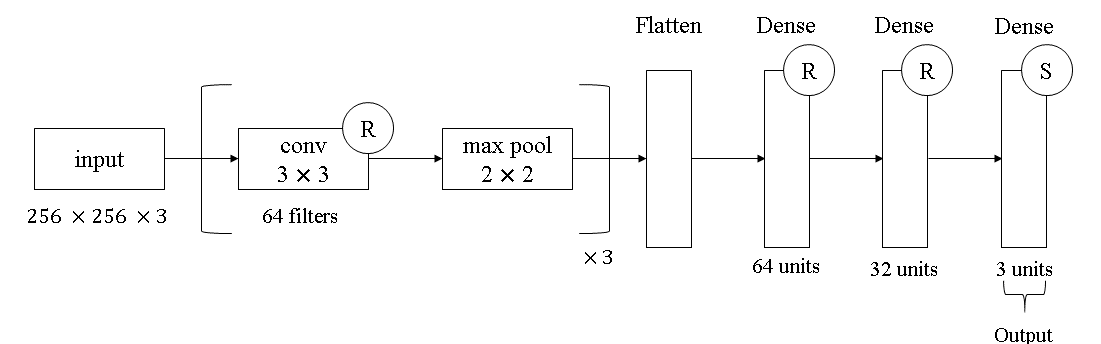

In [ ]:
def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_keras

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

In [50]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')])

    model.compile(
       optimizer=Adam(),
       loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy', recall, precision, f1])

    return model


model = create_model()

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 64)      

In [ ]:
history = model.fit(
   train_generator,
   epochs=30,
   verbose=1,
   validation_data=validation_generator)

Epoch 1/30
11/11 [==============================] - 6s 416ms/step - loss: 1.1463 - accuracy: 0.3231 - recall: 0.0227 - precision: 0.0227 - f1: 0.0227 - val_loss: 1.0949 - val_accuracy: 0.3359 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/30
11/11 [==============================] - 4s 399ms/step - loss: 1.0991 - accuracy: 0.3577 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.0926 - val_accuracy: 0.3359 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/30
11/11 [==============================] - 4s 395ms/step - loss: 1.0971 - accuracy: 0.3538 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.0907 - val_accuracy: 0.3740 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/30
11/11 [==============================] - 4s 396ms/step - loss: 1.0885 - accuracy: 0.3808 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.07

## Evaluating the Model Performance

This part of the code calculates and displays a confusion matrix for a trained model’s predictions on a validation dataset. ```test_step_per_epoch``` determines the number of steps needed to cover all validation samples by dividing the total number of samples by the batch size and rounding up. The model then predicts the output probabilities for each class in the validation set. Using the ```true_classes``` and ```predicted_classes```, a confusion matrix is computed to display the classification performance. 

From the ```sklearn.metrics```, the metrics can be calculated using the result from the model's evaluation as well. 

**Accuracy** measures how often predictions match the label.

$$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$$

**Recall** measures the ratio of correctly predicted positive cases to all actual positive cases (TP + FN).

$$Recall = \frac{TP}{TP+FN}$$

**Precision** measures the ratio of correctly predicted positive cases (TP) to total predicted positive cases (TP + FP).

$$Precision = \frac{TP}{TP+FP}$$

**F1 score** measures the balance between precision and recall.

$$F1-Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$



6/6 [==============================] - 0s 37ms/step


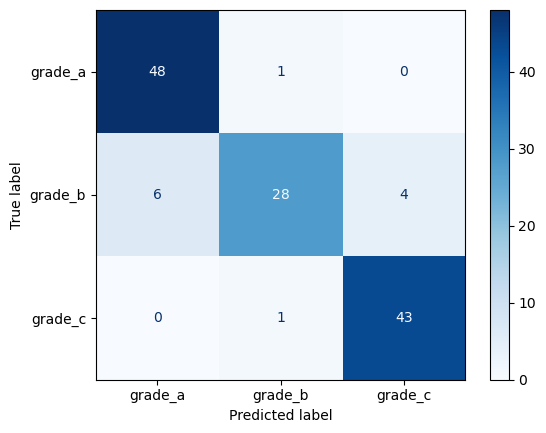

In [52]:
test_step_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

predictions = model.predict(validation_generator, steps=test_step_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(validation_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)

Here's the table summary version of the confusion matrix.
| Parameters               | Grade A | Grade B | Grade C |
|-------------------------|---------|---------|---------|
| True Positives (TP)   | 48      | 28      | 43      |
| False Positives (FP)  | 6       | 2       | 4       |
| False Negatives (FN)  | 1       | 10      | 1       |
| True Negatives (TN)   | 76      | 91      | 83      |

In [53]:
# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9084
Precision: 0.9105
Recall: 0.9084
F1-Score: 0.9049


Using ```matplotlib```, the model's training progression can also be displayed using the line plot. The graph here represents the loss, accuracy, recall, precision, and the f1-score progression troughtout the training. Looking at the result of these graphs, there is neither an indication where the model has a case of overfitting nor underfitting. 

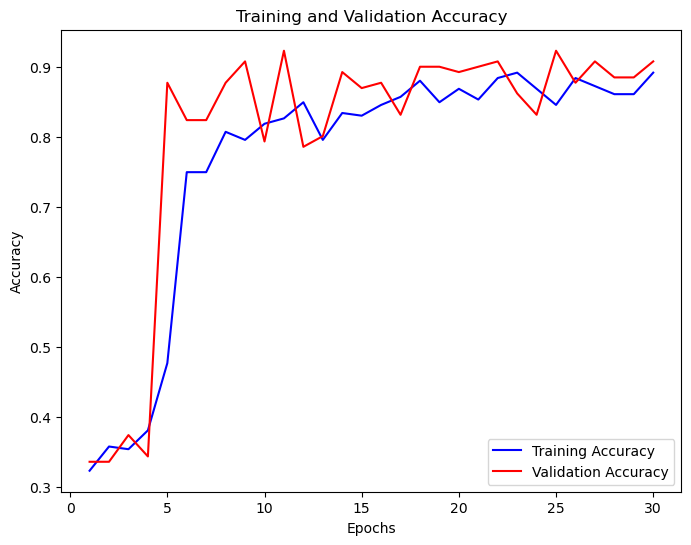

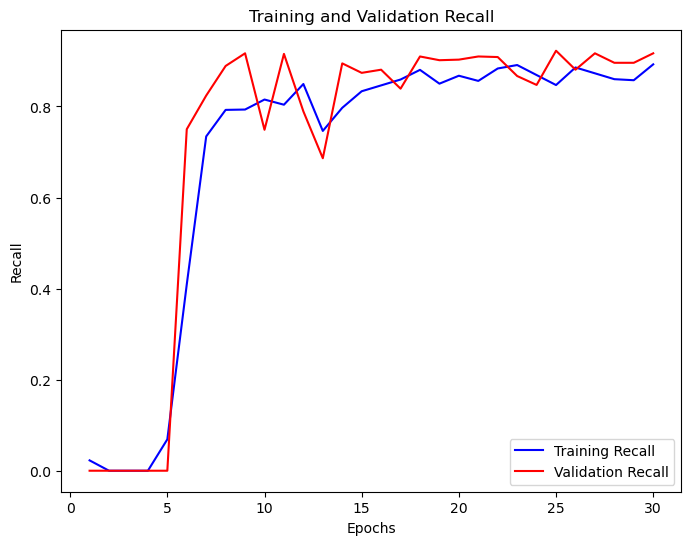

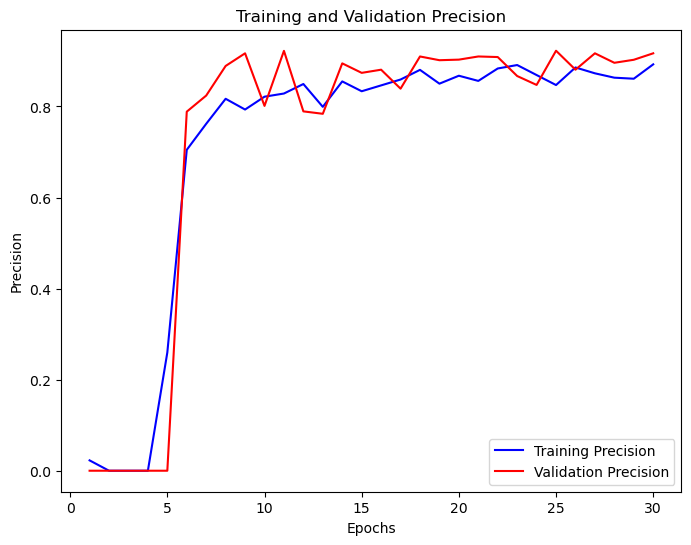

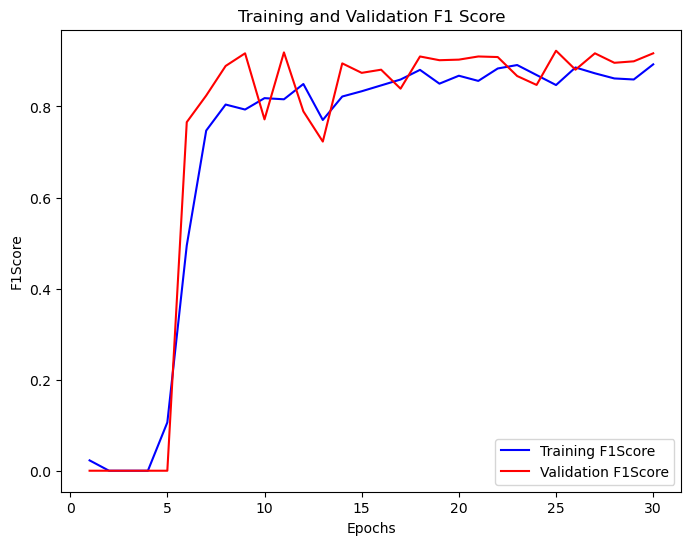

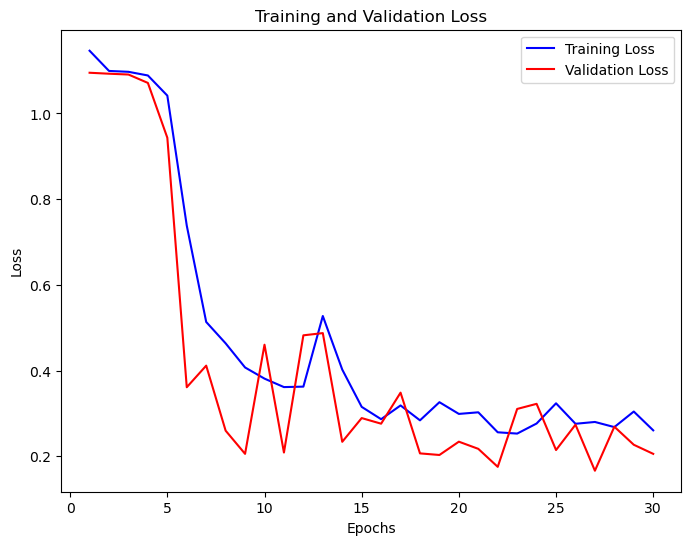

In [54]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
recall = history.history['recall']
val_recall = history.history['val_recall']
precision = history.history['precision']
val_precision = history.history['val_precision']
f1 = history.history['f1']
val_f1 = history.history['val_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the epochs
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(8, 6))
plt.plot(epochs, recall, 'b', label='Training Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(8, 6))
plt.plot(epochs, precision, 'b', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot F1 Score
plt.figure(figsize=(8, 6))
plt.plot(epochs, f1, 'b', label='Training F1Score')
plt.plot(epochs, val_f1, 'r', label='Validation F1Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Deployment and Inference <a id='3' ></a>

## Conversion to TensorFlow Lite

After the training process, the trained model was converted to TensorFlow Lite to make it compatible with Edge Impulse.

In [ ]:
Saved_Model = 'saved_model'
tf.saved_model.save(model, Saved_Model)
loaded = tf.saved_model.load(Saved_Model)

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

converter = tf.lite.TFLiteConverter.from_saved_model(Saved_Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

class_names = ['Grade A', 'Grade B', 'Grade C']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

## Deployment to Edge Impulse

The converted model would then be exported to Edge Impulse. Edge Impulse is a cloud-based platform for machine learning operations that enables the development of edge systems. Edge Impulse will provide several options, namely 'Model input' which is filled as 'Image (RGB)' because each model uses a color image dataset. 

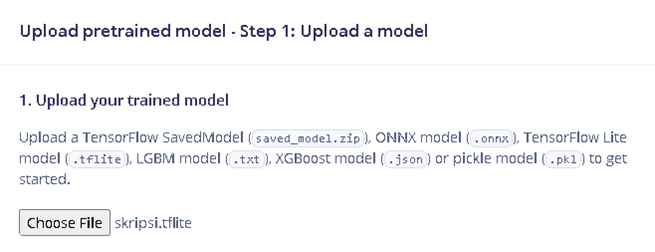

Then the option 'How is your input scaled?' which is filled with 'Pixels ranging 0..1' because in the pre-processing process all images have been normalized, then the option 'Model output' which is filled with 'Classification' according to the model's purpose, and finally the option 'Output labels' which is filled according to the class name. After the process, the model can be used for deployment.

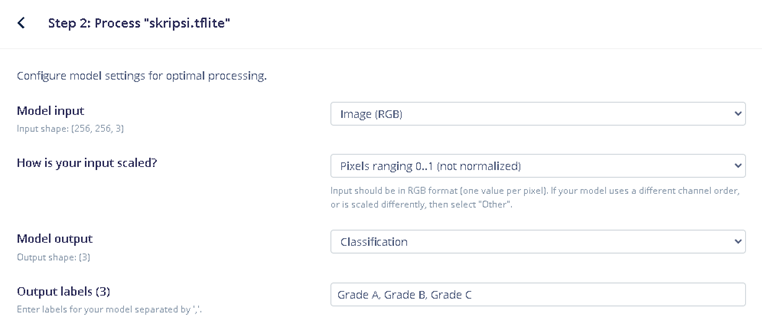

## Inference with ESP32-CAM

To enable the ESP32 in the Arduino IDE, the ESP32 board definition must be added. This process begins by opening the Arduino IDE and navigating to the Preferences section. In the "Additional Boards Manager URLs" field, the URL "https://raw.githubusercontent.com/espressif/arduino-esp32/gh-pages/package_esp32_index.json" must be added. Next, the compilation tools and libraries necessary for ESP32 development in the Arduino IDE can be downloaded by navigating to the Boards Manager section and downloading "esp32 by Espressif." This process will make the Camera Web Server sketch available in the Arduino IDE. The Camera Web Server will enable the ESP32-CAM to function as an IP camera accessible from devices on the same local network.

After gaining access to the Camera Web Server sketch, the script within the program can be modified to connect the ESP32-CAM to Wi-Fi. This can be done by modifying the SSID (network name) and password in the program to match the desired network. During the initial ESP32-CAM configuration, the program script is designed to display the device's IP address in the serial monitor. This IP address is the ESP32-CAM's unique identifier on the local network. For video streaming, the ESP32-CAM typically uses the MJPEG (Motion JPEG) protocol over HTTP (Hypertext Transfer Protocol). MJPEG works by sending a series of individual JPEG images sequentially, creating the illusion of video. To access this video stream and the camera's web configuration interface, a complete URL is required. This URL combines the device's IP address, a port number (usually 81 for MJPEG), and a specific endpoint (/stream). Thus, the URL to access the video stream will have the template "http://<ESP32-CAM_IP_ADDRESS>:<PORT>/stream". During the initial ESP32-CAM setup, the program script is configured to print the device's IP address, omitting the ":81/stream" endpoint, which allows access to the camera's web configuration interface. Here's the URL output of the program.

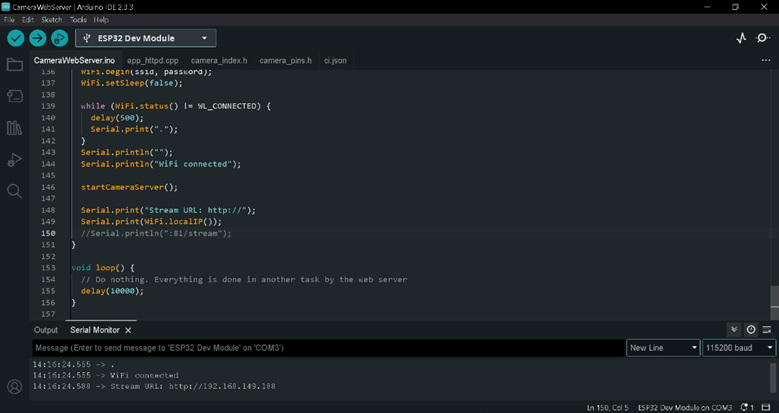

On the webpage, users can change parameters such as camera configuration. 

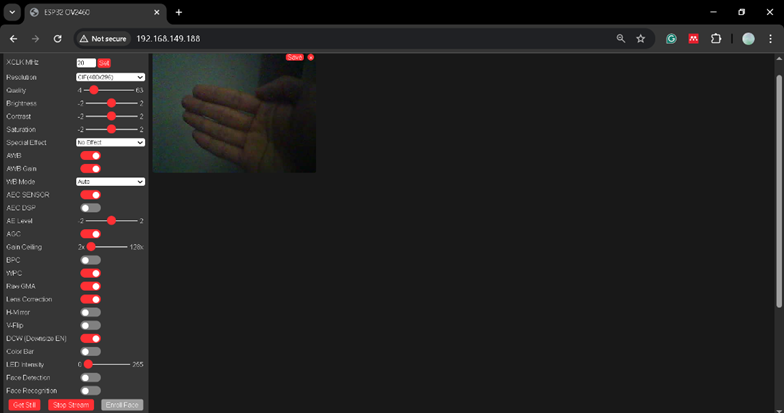

After the user's settings were applied, the script was rerun with the IP address endpoint "/:81stream" enabling video streaming.

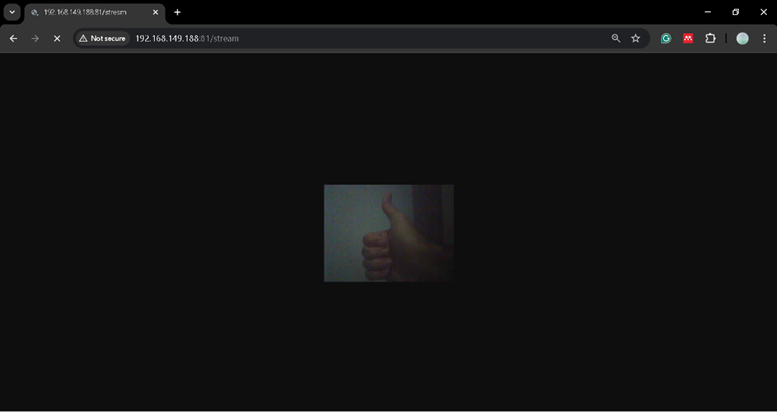

Once the URL for the video stream in the ESP32-CAM is accessible, the output of this video stream must be connected to Edge Impulse. The URL on the ESP32-CAM cannot be accessed directly with Edge Impulse, so a virtual camera application that can access the video stream in the URL is required. One application that can access this video stream is OBS (Open Broadcaster Software). This application can be granted access to the video stream by entering the video stream URL in the "Media Source" section of the "Sources" section and activating the virtual camera in the application so that it can be detected by Edge Impulse.

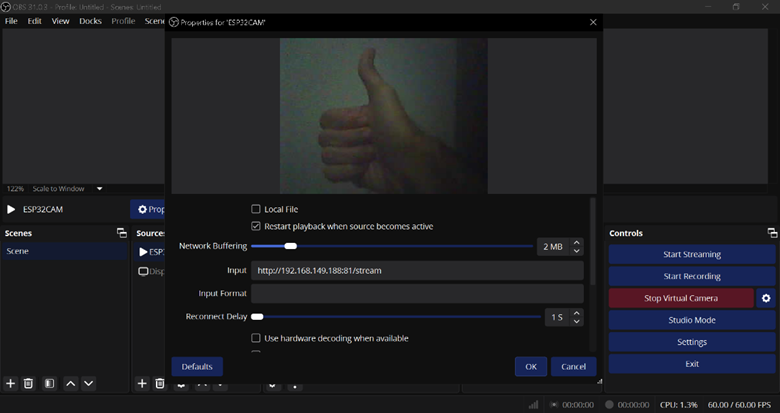

This process allows the ESP32-CAM to act as a data acquisition device, while classification is handled by Edge Impulse cloud-based processing. The classification results are displayed by Edge Impulse, which will indicate the probability of the fruit being detected in front of the ESP32-CAM camera. The higher this probability, the more confident the model is that the detected object matches its classification.

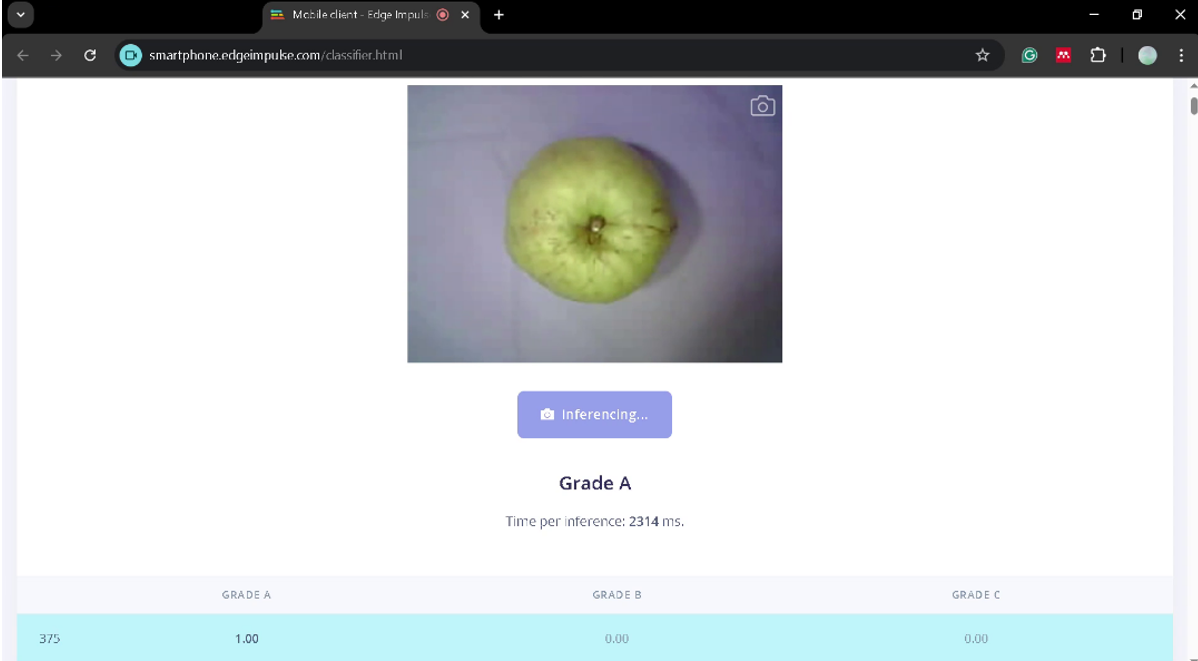